# 要研究的三类故障

- 欠压
    - 整车电压低于临界电压，电池过热而烧毁
- 过温
    - 锂电池工作温度高于额定工况
- 一致性差
    - 一致性是指一组锂电池参数的趋同性
    - [相关网址](https://baijiahao.baidu.com/s?id=1583408279124293251&wfr=spider&for=pc&qq-pf-to=pcqq.c2c)
    - 主要有
        - 电压不一致
        - 内阻不一致
        - 容量不一致
        - 温升不一致
    - 评价指标
        - 有用标准差的、有用极差的

# 数据的一些特征

- 每10s一个数据
- 数据中``mbv``指的是单体电池电压
- 数据中``etpd``指的是电池探针温度

# 国标

- 总电压``total_voltage``范围 0V-1000V
- 总电流``total_current``范围 -1000A-1000A
- 电池剩余电量SOC(State of Charge)
- 单体电池电压``mbv``最高值范围 0-15V
- 单体电池电压``mbv``最低值范围 0-15V
- 电池探针``etpd``最高温度范围 -40-210°
- 电池探针``etpd``最低温度范围 -40-210°
- 最高报警等级``max_level``范围 0 1 2 3
    - 0 无故障
    - 1 1级故障 不影响车辆正常行驶
    - 2 2级故障 影响车辆性能 需驾驶员限制行驶
    - 3 3级故障 立即停车处理或请求救援
- 通用报警标志位``general_sign``
    - 第0位 1:温度差异报警
    - 第1位 1:电池高温报警
    - 第2位 1:车载储能装置类型过压报警
    - 第3位 1:车载储能装置类型欠压报警
    - 第4位 1:SOC低报警
    - 第5位 1:单体电池过压报警
    - 第6位 1:单体电池欠压报警
    - 第7位 1:SOC过高报警
    - 第8位 1:SOC跳变报警
    - 第9位 1:可充电储能系统不匹配报警
    - 第10位 1:电池单体一致性差报警
    - 第11位 1:绝缘报警
    - 第12位 1:DC-DC温度报警
    - 第13位 1:制动系统报警
    - 第14位 1:DC-DC状态报警
    - 第15位 1:驱动电机控制器温度报警
    - 第16位 1:高压互锁状态报警
    - 第17位 1:驱动电机温度报警
    - 第18位 1:车载储能装置类型过充
    - 第19-31位 预留

In [1]:
import pandas as pd 
import numpy as np  
import matplotlib.pyplot as plt 
import seaborn as sns 

sns.set_style('dark')
plt.rcParams['font.family'] = 'Palatino Linotype'

In [2]:
class Car:
    def __init__(self,path):
        self.data = pd.read_csv(path)
        self.battery_num = None # 车中电池总数
        self.probe_num = None # 车中电池温度探针总数
    
    def init_params(self):
        self.battery_num = self.data['total_mer_battery'][0]
        self.probe_num = self.data['total_temp_probe'][0]

# 读取编号8487车(过温)的数据

- 数据总量 1598187条
- 报警位``general_sign``的值
    - 0 无报警
    - 2 电池高温报警 数据较多 ``max_level``为2或3
    - 2048 DC-DC温度报警 只有6条数据 ``max_level``均为1
- 可以将该车的故障视为电池高温报警

In [3]:
path = '8487.csv'
car = Car(path)
car.init_params()

E:\AnacondaEnv\Anaconda\envs\usualEnv\lib\site-packages\IPython\core\interactiveshell.py:3347: DtypeWarning: Columns (6,10,11,24,143) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


- 数据的所有列名

In [4]:
col_lst = car.data.columns

# 异常数据的范围

- 第一部分数据 ``449092:449961``
    - 为2级警报
    - 有870条数据
- 第二部分数据 ``521261:521388``
    - 为2级警报
    - 有128条数据
- 第三部分数据 ``529624:530171``
    - 2级警报 305条
    - 3级警报 243条

In [5]:
# 训练数据的范围
TRAIN_LEFT = 300000
TRAIN_RIGHT = 340000
# 异常数据所在的范围
L_1 = 449092
R_1 = 449961
L_2 = 521261
R_2 = 521388
L_3 = 529624
R_3 = 530171

# 重新设置label

In [6]:
# 在data中将所有2级警报和3级警报的flag设置为1 其它的flag为0
car.data['flag'] = 0
for i in range(L_1,R_1+1):
    car.data.loc[i,'flag'] = 1
for i in range(L_2,R_2+1):
    car.data.loc[i,'flag'] = 1
for i in range(L_3,R_3+1):
    car.data.loc[i,'flag'] = 1

# 数据清洗

- 对数据有明显错误的值 进行修改

In [7]:
data = car.data

## 清洗max_temp

In [8]:
idxs = list(data[data['max_temp']>100].index)
for idx in idxs:
    data.loc[idx,'max_temp'] = data.loc[idx-1,'max_temp']

<AxesSubplot:>

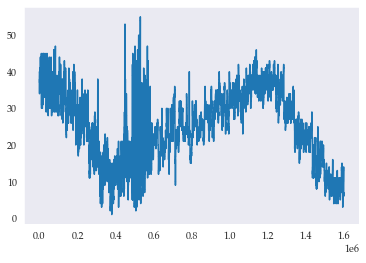

In [9]:
data['max_temp'].plot()

## 清洗min_temp

In [10]:
idxs = list(data[data['min_temp']>100].index)
for idx in idxs:
    data.loc[idx,'min_temp'] = data.loc[idx-1,'min_temp']

<AxesSubplot:>

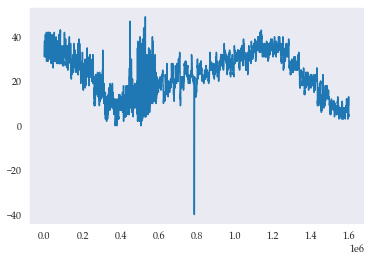

In [11]:
data['min_temp'].plot()

## 清洗SOC

In [12]:
idxs = list(data[data['soc']==100].index)
for idx in idxs:
    data.loc[idx,'soc'] = data.loc[idx-1,'soc']

## 清洗max_bat_mer_v

<AxesSubplot:>

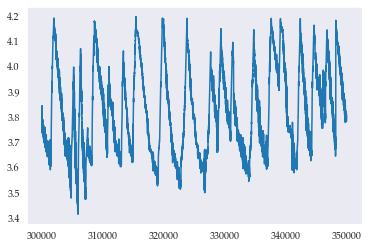

In [13]:
# 清洗训练数据的异常值 无异常
max_bat_mer_v = car.data.loc[TRAIN_LEFT:TRAIN_RIGHT+10000]['max_bat_mer_v']
max_bat_mer_v.plot()

<AxesSubplot:>

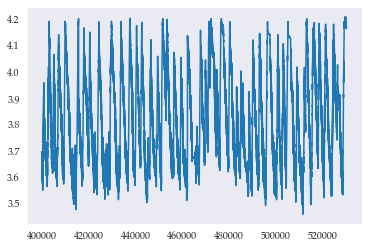

In [14]:
# 清洗从400000-R_3的异常值 无异常
max_bat_mer_v = car.data.loc[400000:R_3]['max_bat_mer_v']
max_bat_mer_v.plot()

## 清洗min_bat_mer_v

<AxesSubplot:>

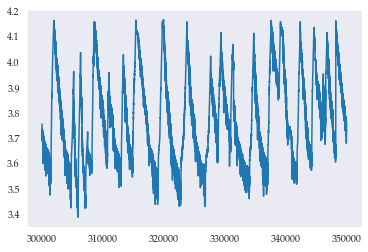

In [15]:
# 清洗训练数据的异常值 无异常
min_bat_mer_v = car.data.loc[TRAIN_LEFT:TRAIN_RIGHT+10000]['min_bat_mer_v']
min_bat_mer_v.plot()

<AxesSubplot:>

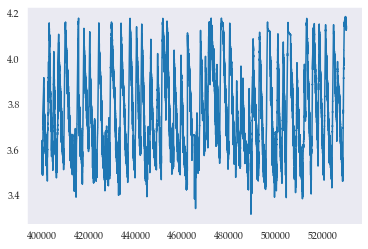

In [16]:
# 清洗从400000-R_3的异常值 无异常
min_bat_mer_v = car.data.loc[400000:R_3]['min_bat_mer_v']
min_bat_mer_v.plot()

## 清洗total_voltage

<AxesSubplot:>

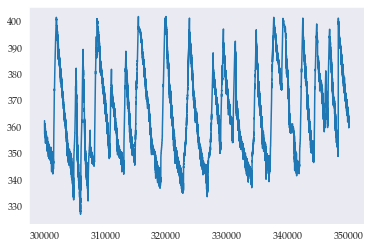

In [17]:
# 清洗训练数据的异常值 无异常
total_voltage = car.data.loc[TRAIN_LEFT:TRAIN_RIGHT+10000]['total_voltage']
total_voltage.plot()

<AxesSubplot:>

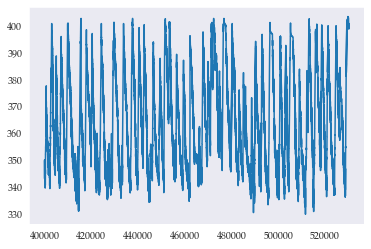

In [18]:
# 清洗从400000-R_3的异常值 无异常
total_voltage = car.data.loc[400000:R_3]['total_voltage']
total_voltage.plot()

## 清洗total_current

- ``total_current``的数据好奇怪

<AxesSubplot:>

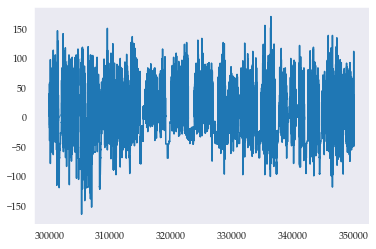

In [19]:
# 清洗训练数据的异常值 无异常
total_current = car.data.loc[TRAIN_LEFT:TRAIN_RIGHT+10000]['total_current']
total_current.plot()

<AxesSubplot:>

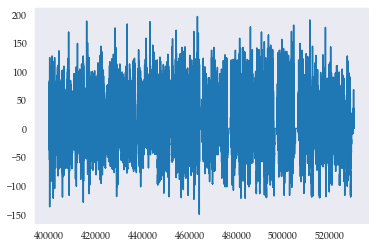

In [20]:
# 清洗从400000-R_3的异常值 无异常
total_current = car.data.loc[400000:R_3]['total_current']
total_current.plot()

In [21]:
warning_1 = car.data.loc[L_1:R_1]
warning_2 = car.data.loc[L_2:R_2]
warning_3 = car.data.loc[L_3:R_3]

# 数据的一些特征

## 充电状态和过温的关系

- 数据中``charge_state=1``表示停车充电 ``charge_state=3``表示未充电
- 怀疑因为充电导致过温

In [22]:
# 异常数据的充电状态
warning_1['charge_state'].value_counts(),warning_2['charge_state'].value_counts(),warning_3['charge_state'].value_counts()

(3             516
 1             350
 dropped_fe      4
 Name: charge_state, dtype: int64,
 3    109
 1     17
 4      2
 Name: charge_state, dtype: int64,
 3             370
 1             143
 dropped_fe     35
 Name: charge_state, dtype: int64)

## 对于正常数据 充电不会导致温度陡增

- 300000-310000之间的数据有点奇怪

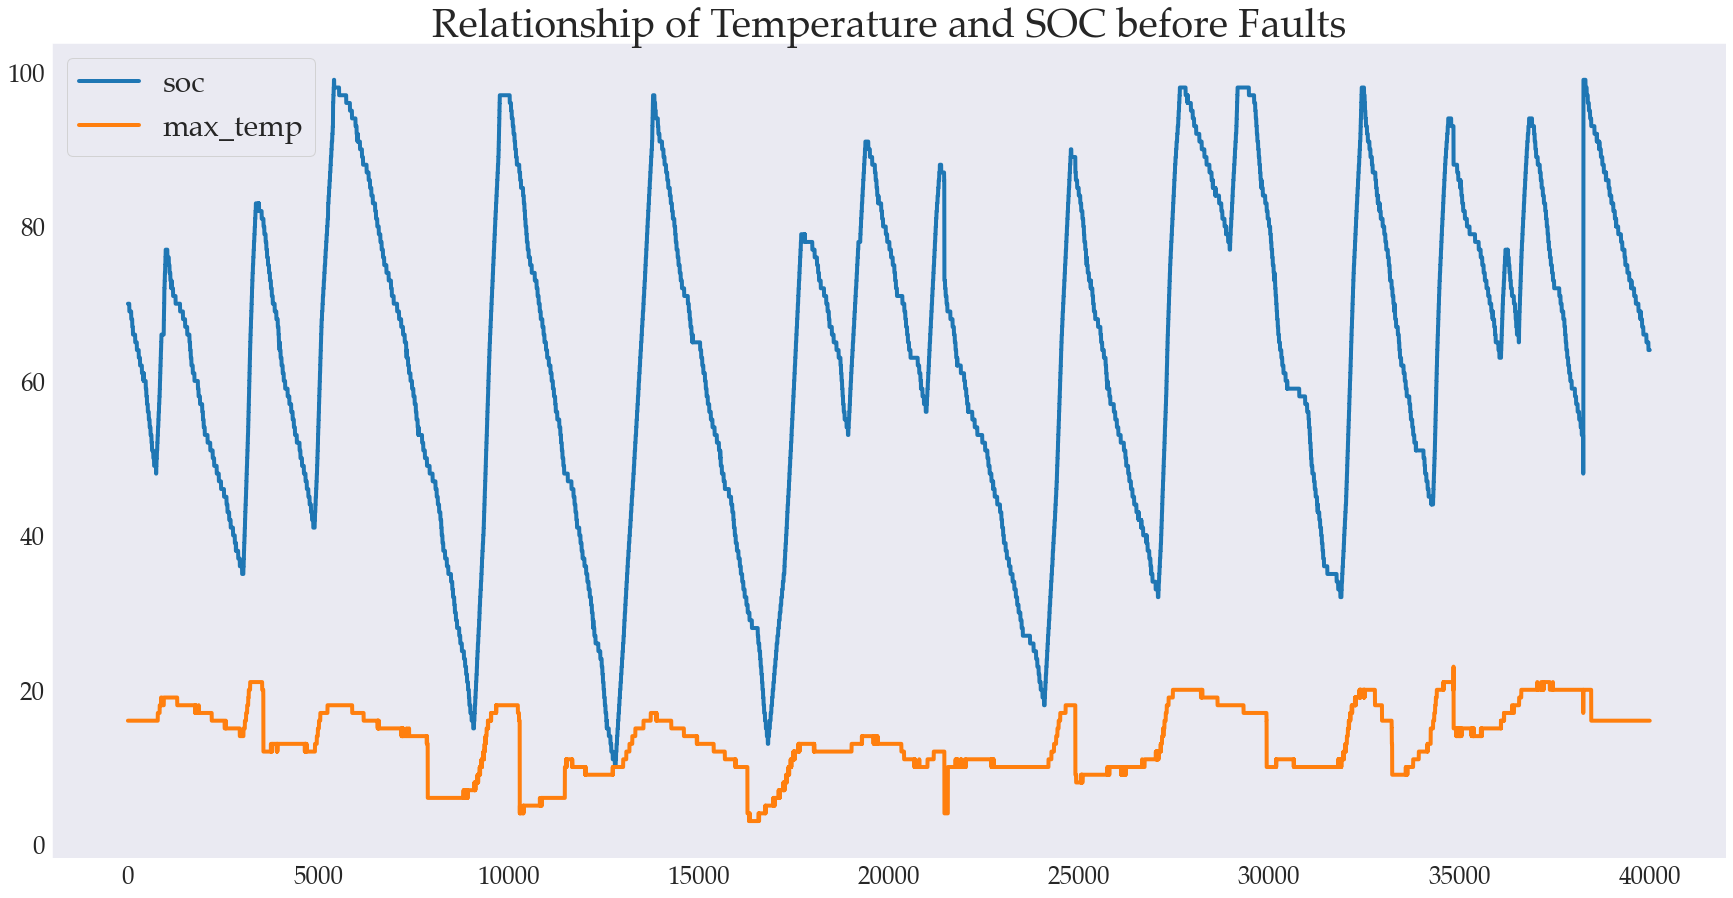

In [26]:
fig = plt.figure(figsize=(30,15))

plt.tick_params(labelsize=25)
plt.title('Relationship of Temperature and SOC before Faults',fontsize=40)
plt.plot(car.data.loc[TRAIN_LEFT+10000:TRAIN_RIGHT+10000]['soc'].values,linewidth=4,label='soc')
plt.plot(car.data.loc[TRAIN_LEFT+10000:TRAIN_RIGHT+10000]['max_temp'].values,linewidth=4,label='max_temp')
plt.legend(fontsize=30)

plt.show()

## 异常数据 充电会导致数据飙升

- 这个特征仅在第二次故障前明显

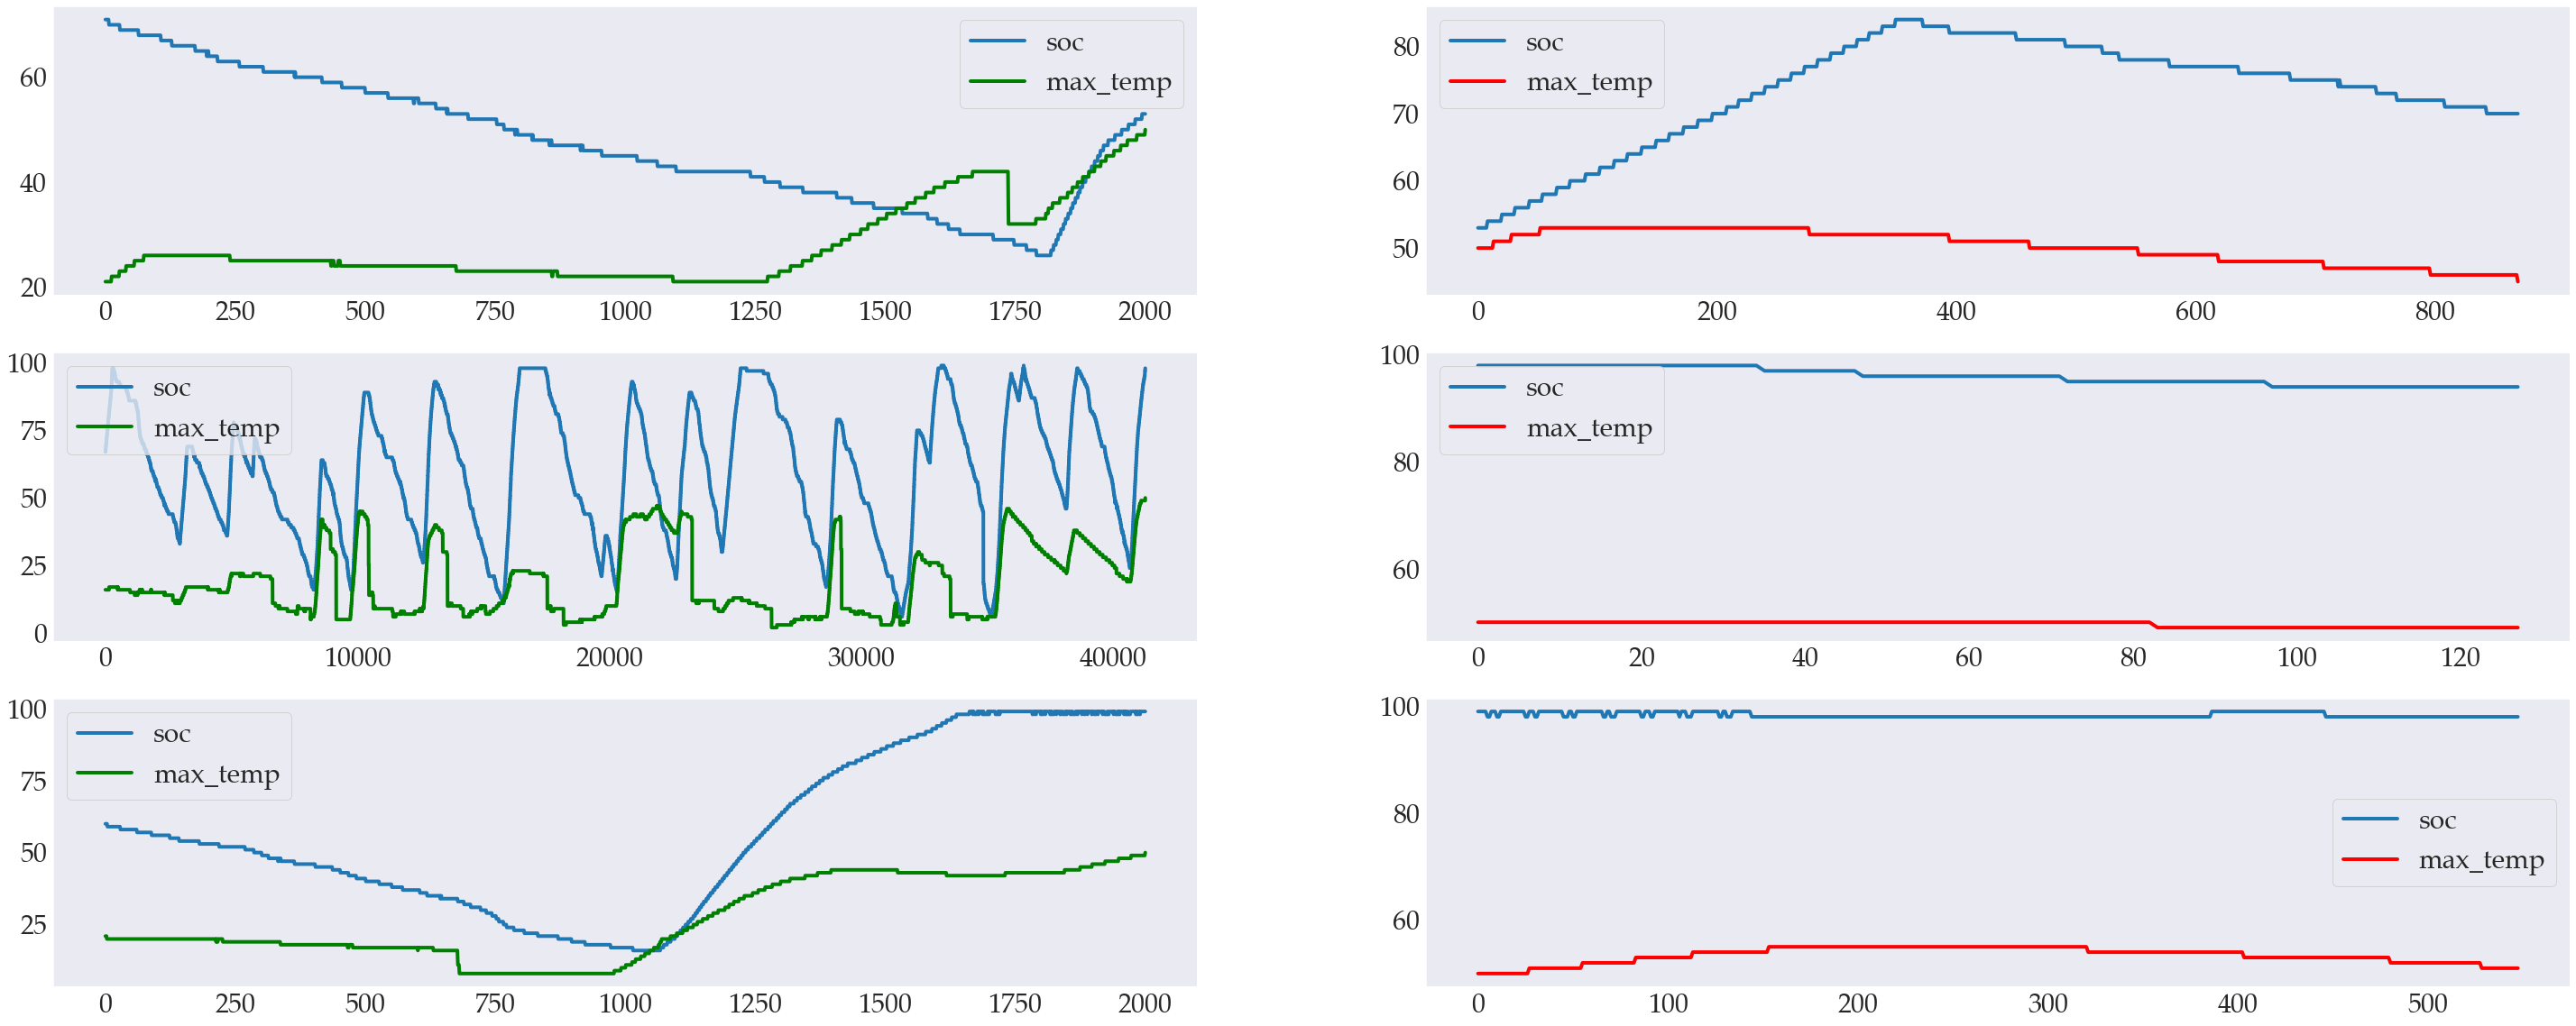

In [32]:
fig = plt.figure(figsize=(50,20))

plt.subplot(321)
plt.tick_params(labelsize=30)
plt.plot(car.data.loc[L_1-2000:L_1]['soc'].values,linewidth=4,label='soc')
plt.plot(car.data.loc[L_1-2000:L_1]['max_temp'].values,linewidth=4,label='max_temp',color='g')
plt.legend(fontsize=30)

plt.subplot(322)
plt.tick_params(labelsize=30)
plt.plot(warning_1['soc'].values,linewidth=4,label='soc')
plt.plot(warning_1['max_temp'].values,linewidth=4,label='max_temp',color='r')
plt.legend(fontsize=30)

plt.subplot(323)
plt.tick_params(labelsize=30)
plt.plot(car.data.loc[480000:L_2]['soc'].values,linewidth=4,label='soc')
plt.plot(car.data.loc[480000:L_2]['max_temp'].values,linewidth=4,label='max_temp',color='g')
plt.legend(fontsize=30)

plt.subplot(324)
plt.tick_params(labelsize=30)
plt.plot(warning_2['soc'].values,linewidth=4,label='soc')
plt.plot(warning_2['max_temp'].values,linewidth=4,label='max_temp',color='r')
plt.legend(fontsize=30)

plt.subplot(325)
plt.tick_params(labelsize=30)
plt.plot(car.data.loc[L_3-2000:L_3]['soc'].values,linewidth=4,label='soc')
plt.plot(car.data.loc[L_3-2000:L_3]['max_temp'].values,linewidth=4,label='max_temp',color='g')
plt.legend(fontsize=30)

plt.subplot(326)
plt.tick_params(labelsize=30)
plt.plot(warning_3['soc'].values,linewidth=4,label='soc')
plt.plot(warning_3['max_temp'].values,linewidth=4,label='max_temp',color='r')
plt.legend(fontsize=30)

plt.show()

# 左侧图为异常前一段时间 右侧图为异常时

## 过温和电池探针温度的关系

- 在预警之前很长时间 温度是比较稳定的
- 在较接近预警时间 温度会呈现有规律的变化

### 第一次故障前后

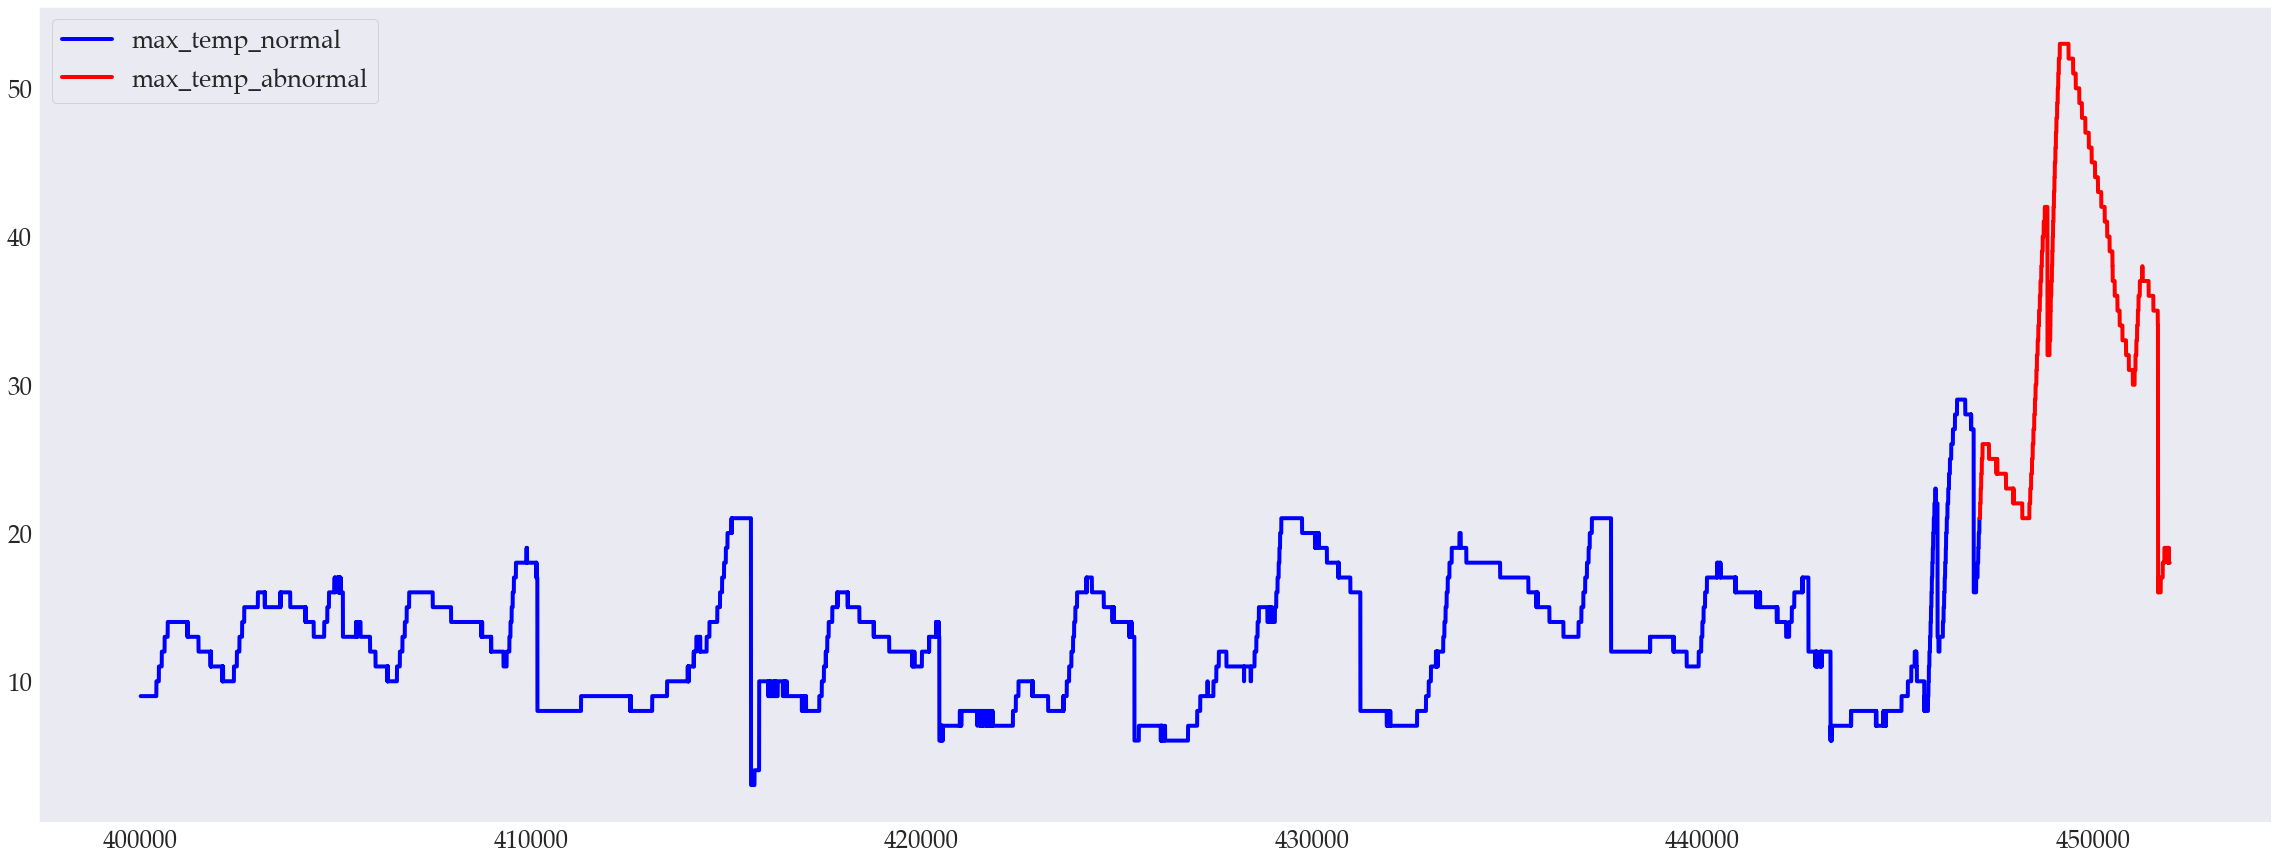

In [25]:
# 第一次故障前后max_temp
fig = plt.figure(figsize=(40,15))

plt.tick_params(labelsize=25)
plt.plot(car.data.loc[400000:L_1-2000]['max_temp'],linewidth=4,label='max_temp_normal',color='b')
plt.plot(car.data.loc[L_1-2000:R_1+2000]['max_temp'],linewidth=4,label='max_temp_abnormal',color='r')
plt.legend(fontsize=25)

plt.show()

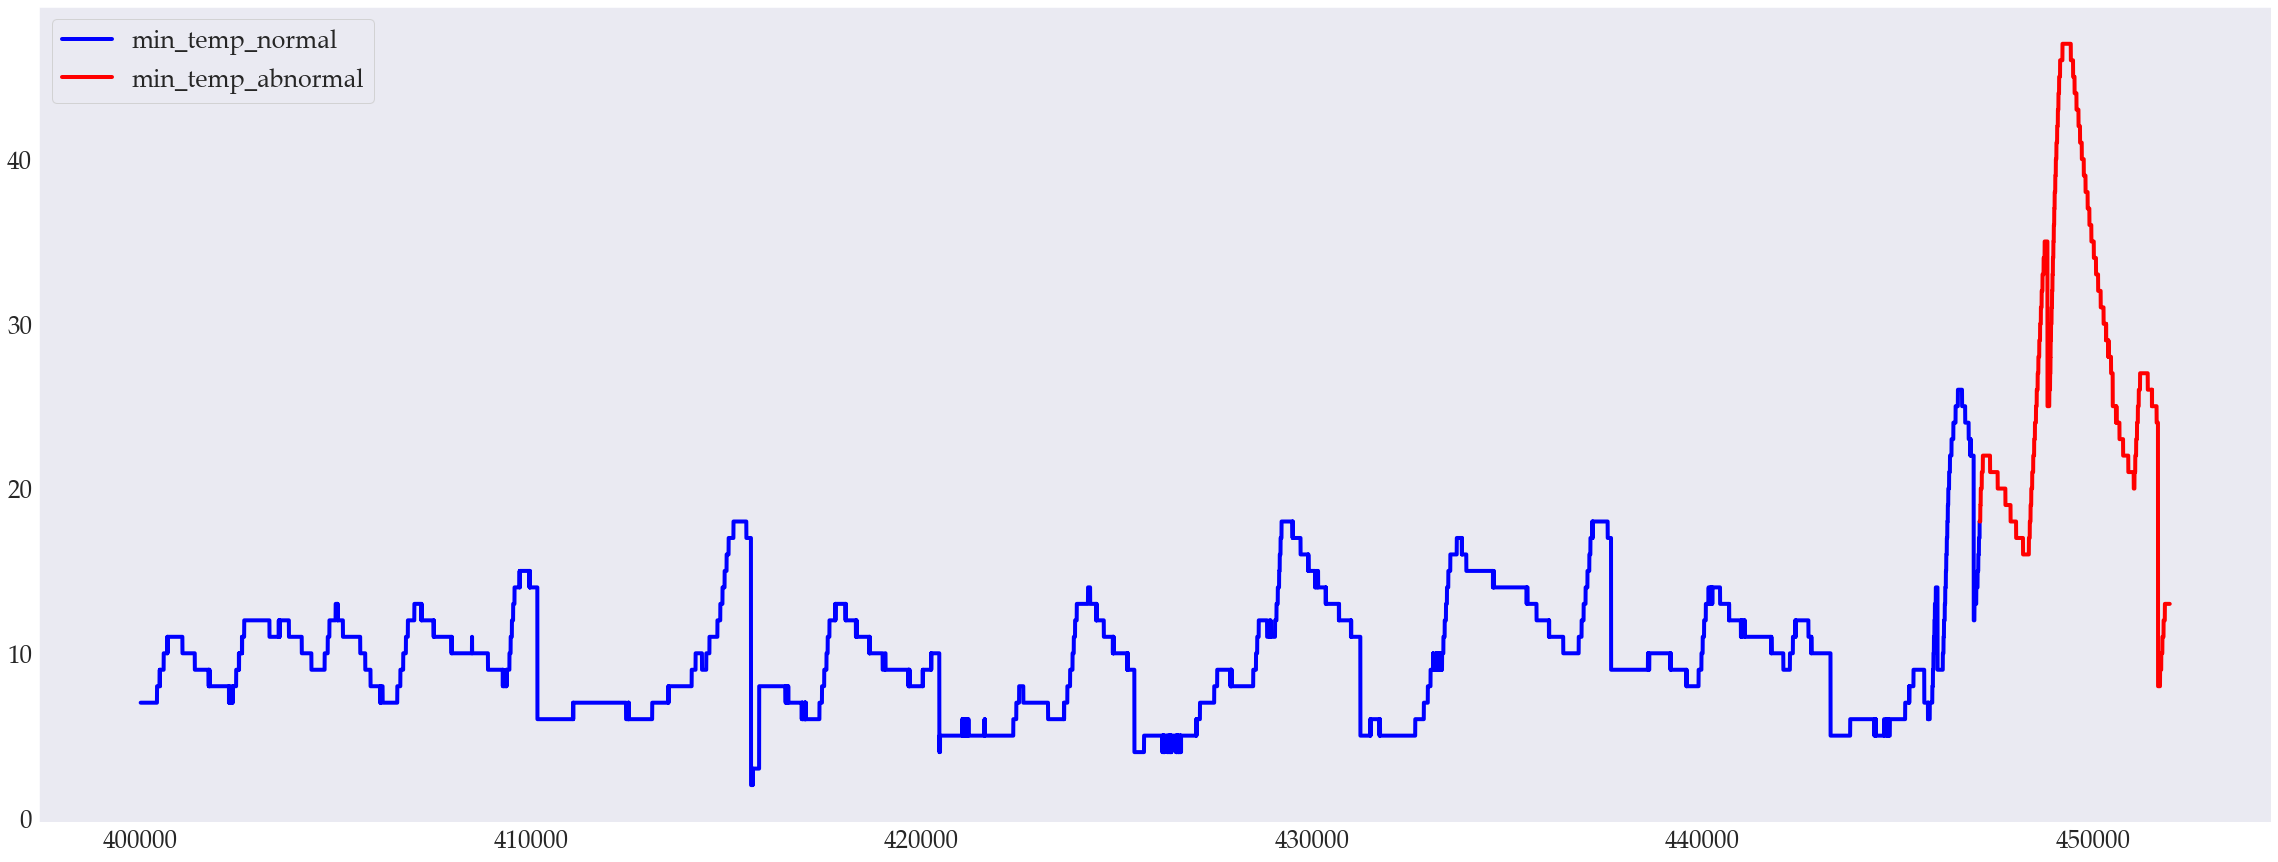

In [26]:
# 第一次故障前后min_temp
fig = plt.figure(figsize=(40,15))

plt.tick_params(labelsize=25)
plt.plot(car.data.loc[400000:L_1-2000]['min_temp'],linewidth=4,label='min_temp_normal',color='b')
plt.plot(car.data.loc[L_1-2000:R_1+2000]['min_temp'],linewidth=4,label='min_temp_abnormal',color='r')
plt.legend(fontsize=25)

plt.show()

### 第二三次故障

- 感觉从下图第一次起伏那么剧烈 就应该认为要发生故障了
- 也可能是因为第一次故障之后 车的状态有点不对 随后发生第二次故障
    - 第一次故障与第二次故障的时间间隔 $\frac{521261-449961}{6\times60\times24}=8.25$天

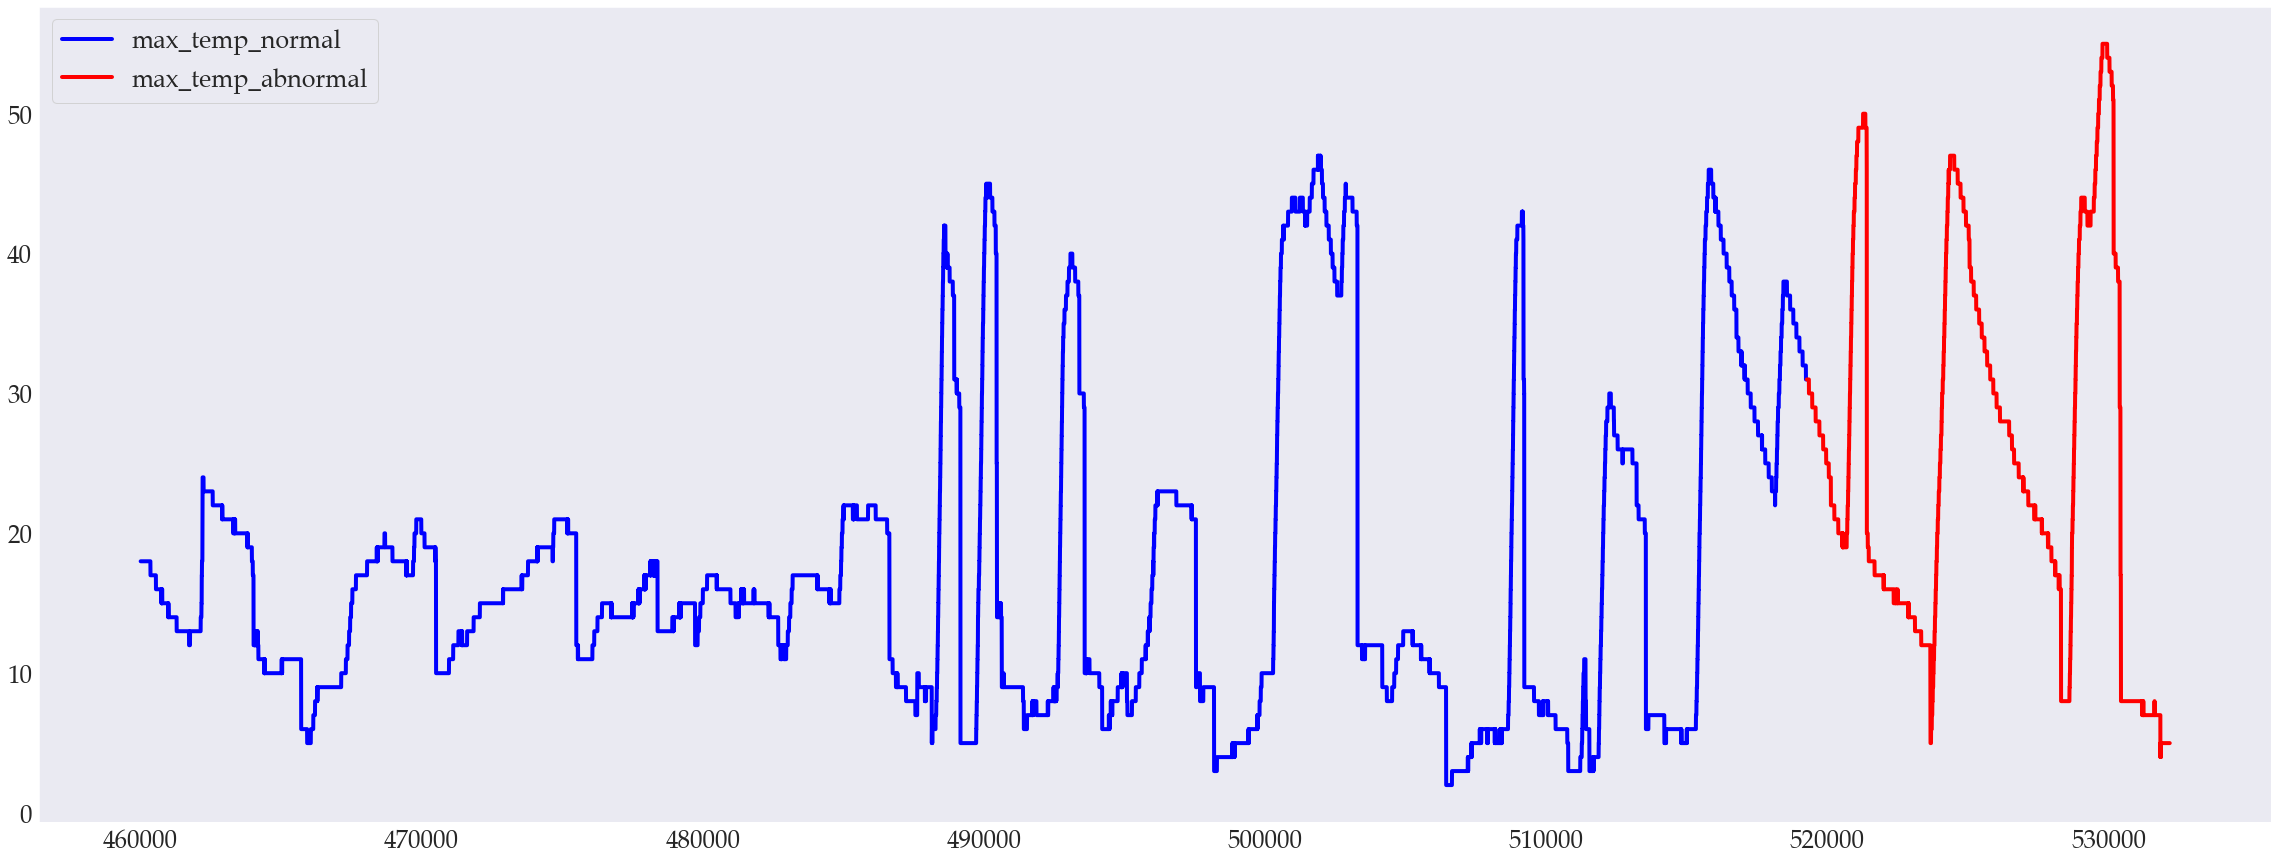

In [27]:
# 第二三次故障max_temp
fig = plt.figure(figsize=(40,15))

plt.tick_params(labelsize=25)
plt.plot(car.data.loc[460000:L_2-2000]['max_temp'],linewidth=4,label='max_temp_normal',color='b')
plt.plot(car.data.loc[L_2-2000:R_3+2000]['max_temp'],linewidth=4,label='max_temp_abnormal',color='r')
plt.legend(fontsize=25)

plt.show()

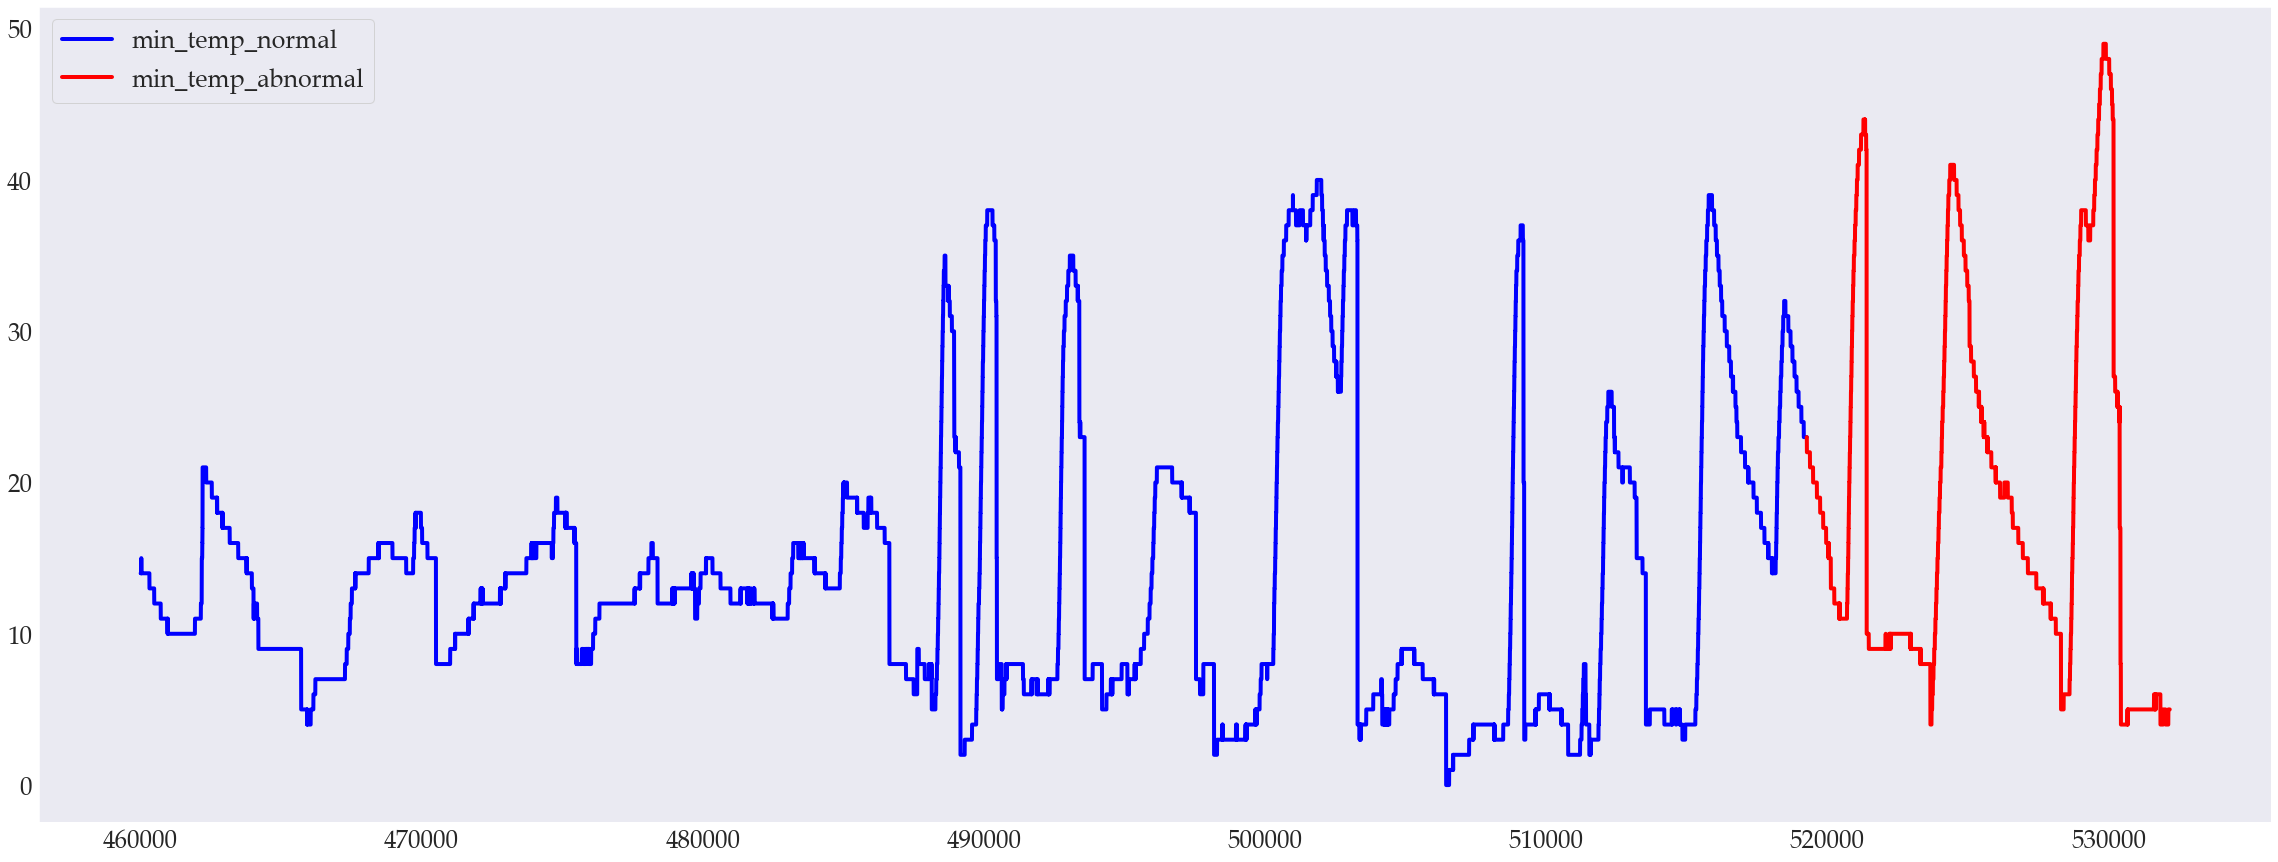

In [28]:
# 第二三次故障min_temp
fig = plt.figure(figsize=(40,15))

plt.tick_params(labelsize=25)
plt.plot(car.data.loc[460000:L_2-2000]['min_temp'],linewidth=4,label='min_temp_normal',color='b')
plt.plot(car.data.loc[L_2-2000:R_3+2000]['min_temp'],linewidth=4,label='min_temp_abnormal',color='r')
plt.legend(fontsize=25)

plt.show()

## 数据预处理 标准化

- AutoEncoder更适合标准化
- One common standardization mistake is: we normalize the entire data and then split into train-test. This is incorrect. Test data should be completely unseen to anything during the modeling. We should, therefore, normalize the training data, and use its summary statistics to normalize the test data (for normalization, these statistics are the mean and variances of each feature)

In [29]:
from sklearn.preprocessing import StandardScaler

# 进行归一化处理
scaler = StandardScaler()

non_train_columns = [
    'sendtime','speed','vehicle_status','run_model','accu_mile','gear','charge_state',
    'accel_pedal_travel','brake_pedal_status','max_v_bat_subsys_serial','max_v_bat_mer_code',
    'min_v_bat_subsys_serial','min_v_bat_mer_code','max_temp_subsys_serial','max_temp_probe_serial',
    'min_temp_subsys_serial','min_temp_probe_serial','total_subsys_v','voltage','current','total_mer_battery',
    'total_subsys_t','subsys_serial','total_temp_probe','ir','dc_dc_status','motor_con_dc_bus_c','total_drive_motor',
    'dm_serial','dm_status','dm_con_temp','dm_speed','dm_torque','dm_temp','motor_con_in_v','max_level',
    'general_sign','gear_bit54','gear_bit30_c','gearbit30_v','location_state_bit0','location_state_bit1',
    'location_state_bit2'
]

data = car.data.loc[TRAIN_LEFT:TRAIN_RIGHT+10000] # 训练数据
data = data.drop(non_train_columns,axis=1)
warning_data = car.data.loc[400000:R_3]
warning_data = warning_data.drop(non_train_columns,axis=1)

data = pd.concat([data,warning_data])

### 清洗etpd

In [30]:
import re

pattern = 'etpd[0-9]+'
etpd_columns = []
for col in col_lst:
    if (re.search(pattern,col) != None):
        etpd_columns.append(col)

etpd_data = data[etpd_columns]
for col in etpd_columns:
    tmp = etpd_data[col]
    idxs = tmp[tmp=='dropped_ff'].index
    for idx in idxs:
        data.loc[idx,col] = data.loc[idx-1,col]

In [31]:
pattern = 'mbv[0-9]+'
mbv_columns = []
for col in col_lst:
    if (re.search(pattern,col) != None):
        mbv_columns.append(col)
mbv_data = data[mbv_columns]
for col in mbv_columns:
    tmp = mbv_data[col]
    idxs = tmp[tmp=='dropped_ff'].index
    for idx in idxs:
        data.loc[idx,col] = data.loc[idx-1,col]

In [32]:
data.to_csv('data_8487.csv')